# Example to use ODA

In [2]:
#!/usr/bin/env python3
"""
Debug script to understand why YOLO is not detecting objects
"""

import os
import sys
from PIL import Image

# Add the current directory to path
sys.path.insert(0, os.path.dirname(os.path.abspath(__file__)))

def debug_yolo_detection():
    """Debug YOLO detection with different parameters"""
    from ultralytics import YOLO
    
    print("Loading YOLO model...")
    model = YOLO("yolov8n.pt")
    print("✓ YOLO model loaded successfully")
    
    # Load test image
    img_path = os.path.join('imgs', 'cars.jpg')
    if not os.path.exists(img_path):
        print(f"✗ Test image not found: {img_path}")
        return False
    
    print(f"Loading test image: {img_path}")
    img = Image.open(img_path)
    print(f"✓ Image loaded: {img.size}")
    
    # Test with different confidence thresholds
    thresholds = [0.1, 0.05, 0.01, 0.001]
    
    for conf in thresholds:
        print(f"\n--- Testing with confidence threshold: {conf} ---")
        
        # Run inference
        results = model(img, conf=conf, verbose=True)
        print(results[0]["boxes"])
        
        # Check results
        if hasattr(results, 'boxes') and results.boxes is not None:
            boxes = results.boxes.xyxy.cpu().numpy()
            scores = results.boxes.conf.cpu().numpy()
            labels = results.boxes.cls.cpu().numpy()
            
            print(f"✓ Detections found: {len(boxes)}")
            for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
                print(f"  Detection {i+1}: class={int(label)}, confidence={score:.6f}, box={box}")
        else:
            print("✗ No detections found")
    
    # Test with different image sizes
    print("\n--- Testing with different image sizes ---")
    sizes = [(640, 640), (800, 600), (1024, 768)]
    
    for size in sizes:
        print(f"\nResizing to {size}")
        resized_img = img.resize(size, Image.LANCZOS)
        
        results = model(resized_img, conf=0.01, verbose=False)
        
        if hasattr(results, 'boxes') and results.boxes is not None:
            boxes = results.boxes.xyxy.cpu().numpy()
            print(f"  Detections: {len(boxes)}")
        else:
            print("  No detections")
    
    return True


NameError: name '__file__' is not defined

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt

from utils.cococls import get_cls

import numpy as np

In [2]:
cococlass = get_cls() # for viz
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

C:\Users\maraw\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated, please use '{weights_param}' instead."
C:\Users\maraw\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## load img

In [4]:
def loadimg(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = cv2.imread(path)
    img = cv2.resize(img, (1024,1024))
    img = img.transpose([2,0,1]) / 255 # 0-1 float!
    return torch.from_numpy(img).unsqueeze(0).to(device).float()

# Execute TTA with ODA

In [5]:
import odach as oda

In [22]:
# Declare TTA variations
tta = [oda.VerticalFlip(), oda.Multiply(0.9), oda.Multiply(1.1)]
scale = [0.8, 0.9, 1, 1.1, 1.2]
# load image
impath = "imgs/cars3.jpg"
img = loadimg(impath)
images=torch.concat((img,img))

#original faster_rcnn input
images=list(img.to(device) for img in images)
# wrap model and tta
model.eval()
tta_model = oda.TTAWrapper(model, tta, scale)
# Execute TTA!
outputs = tta_model(images)

preparing tta for multiscale..


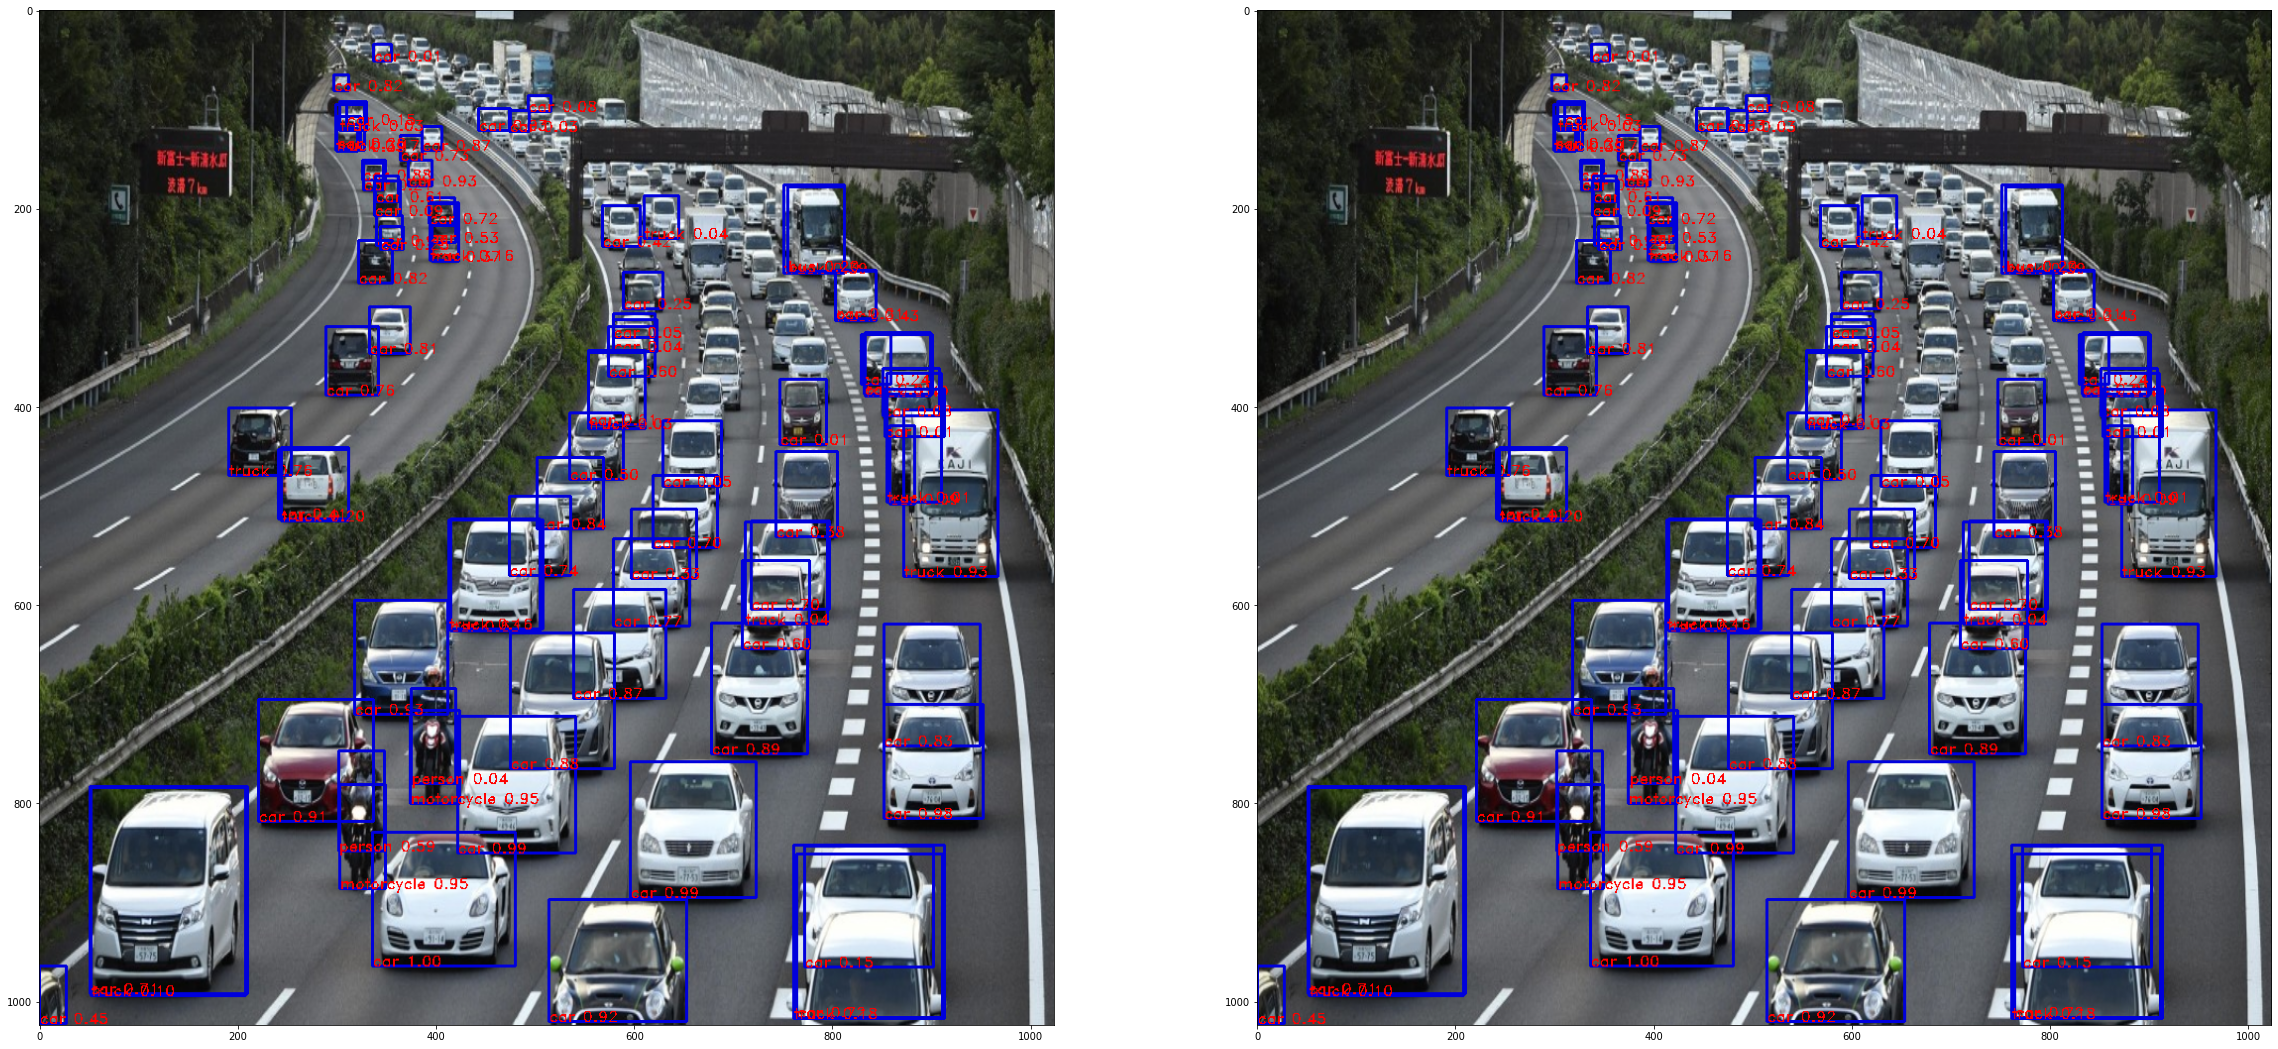

In [85]:
fig, axes = plt.subplots(ncols=len(outputs),figsize=(40,40))
for image,prediction,ax in zip(images,outputs,axes.flat):
    image=(image.cpu().detach().numpy()*255).astype(np.uint8)
    img_channel_last = np.moveaxis(image, 0, -1).copy()

    boxes=prediction['boxes'].cpu().detach().numpy()
    labels=prediction['labels'].cpu().detach().numpy()
    scores=prediction['scores'].cpu().detach().numpy()

    for i, box in enumerate(boxes):
        cv2.rectangle(img_channel_last,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  220, 2)
        cv2.putText(img_channel_last, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction
    img_channel_last = cv2.cvtColor(img_channel_last, cv2.COLOR_BGR2RGB)
    ax.imshow(img_channel_last)
plt.show()

## Multiscale only

In [86]:
# Declare TTA variations
tta = [oda.Multiply(1)]
scale = [0.8, 0.9, 1, 1.1, 1.2]
# load image
impath = "imgs/cars3.jpg"
img = loadimg(impath)
images=torch.concat((img,img))

#original faster_rcnn input
images=list(img.to(device) for img in images)
# wrap model and tta
model.eval()
tta_model = oda.TTAWrapper(model, tta, scale)
# Execute TTA!
outputs = tta_model(images)

preparing tta for multiscale..


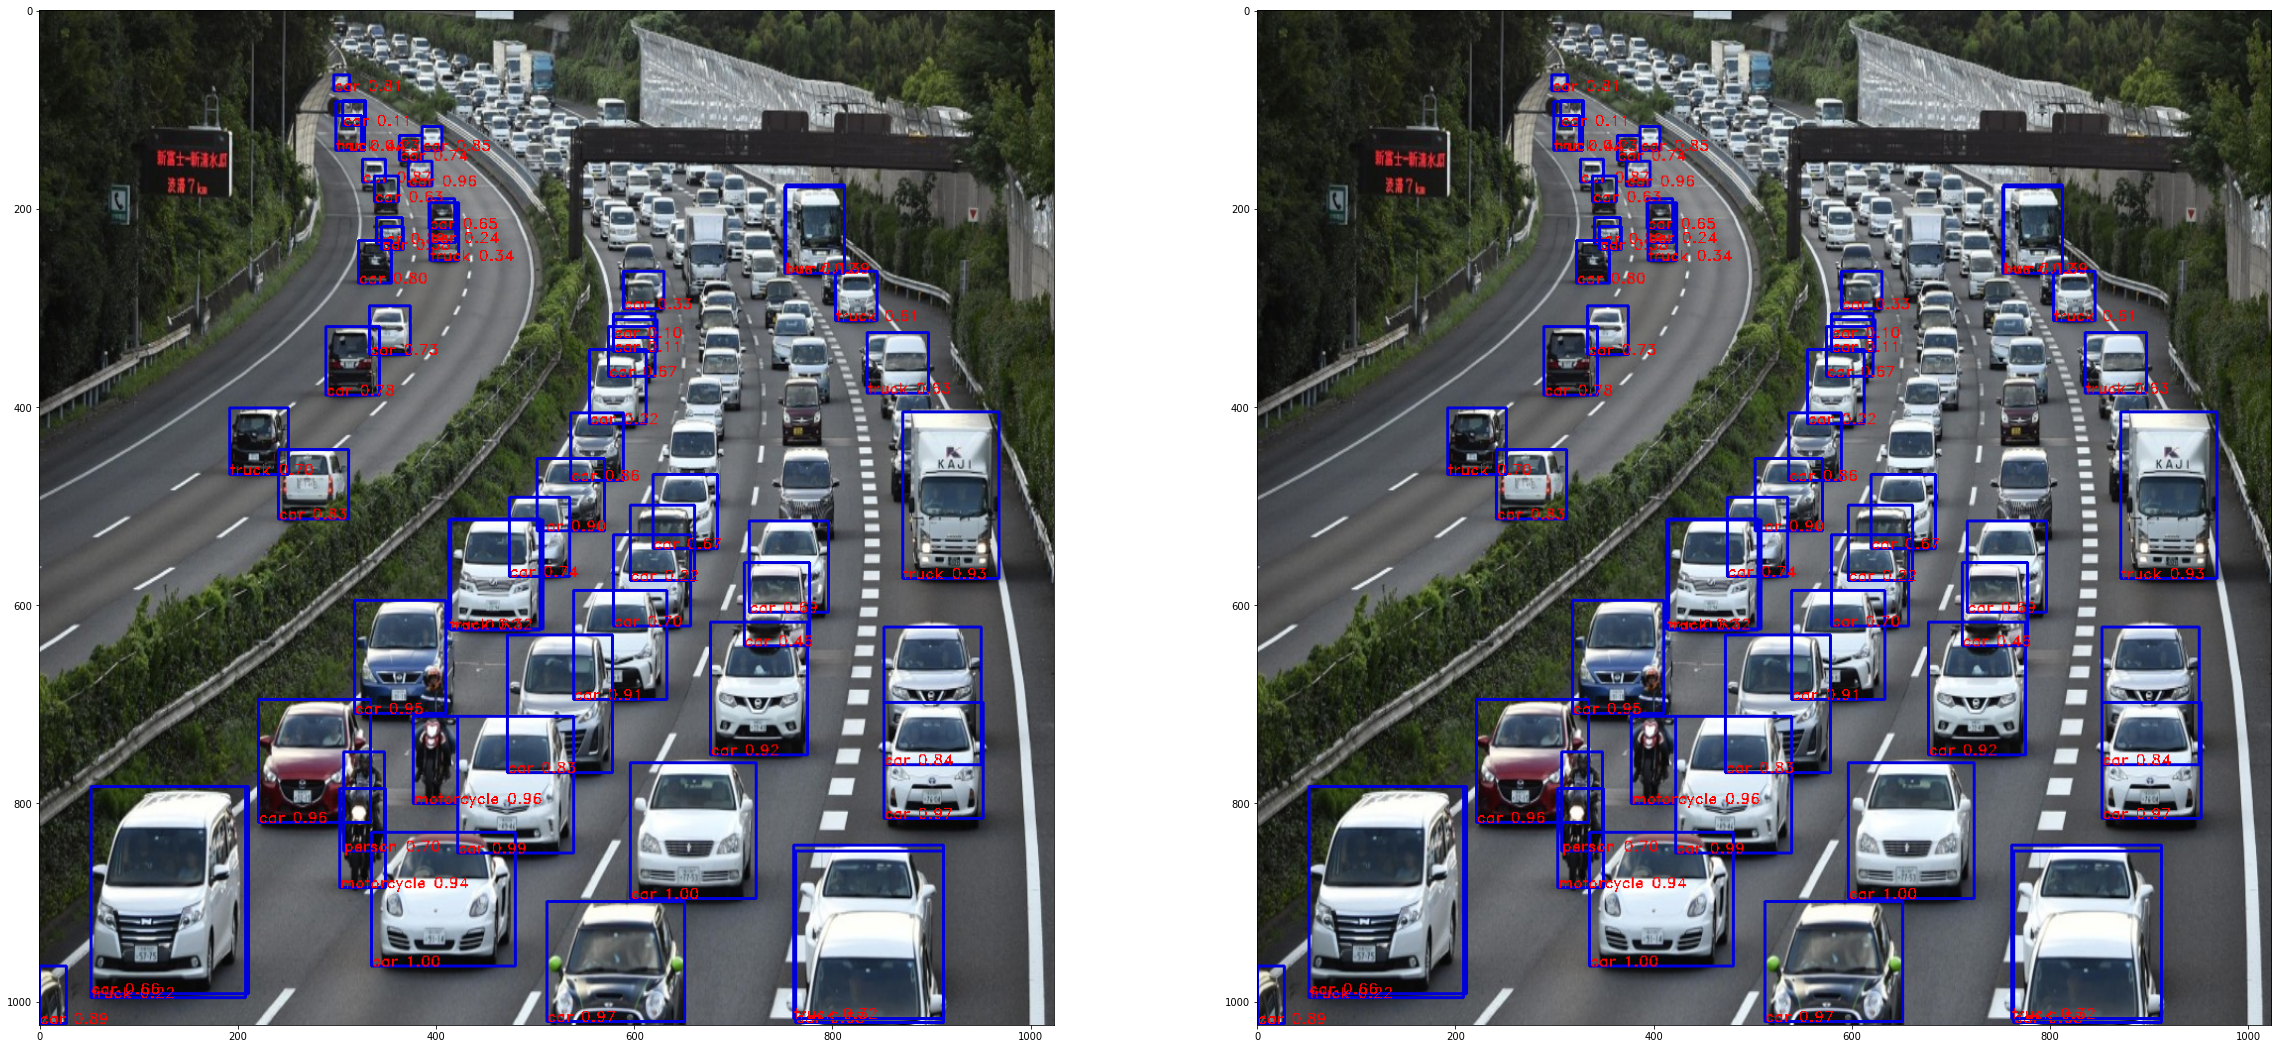

In [87]:
fig, axes = plt.subplots(ncols=len(outputs),figsize=(40,40))
for image,prediction,ax in zip(images,outputs,axes.flat):
    image=(image.cpu().detach().numpy()*255).astype(np.uint8)
    img_channel_last = np.moveaxis(image, 0, -1).copy()

    boxes=prediction['boxes'].cpu().detach().numpy()
    labels=prediction['labels'].cpu().detach().numpy()
    scores=prediction['scores'].cpu().detach().numpy()

    for i, box in enumerate(boxes):
        cv2.rectangle(img_channel_last,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  220, 2)
        cv2.putText(img_channel_last, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction
    img_channel_last = cv2.cvtColor(img_channel_last, cv2.COLOR_BGR2RGB)
    ax.imshow(img_channel_last)
plt.show()